In [2]:
from DiscEvolution.grid import Grid
from DiscEvolution.star import SimpleStar
from DiscEvolution.disc_winds import DiskWindEvolution
from DiscEvolution.eos import ChambersEOS
from DiscEvolution.dust import DustGrowthTwoPop, SingleFluidDrift
from DiscEvolution.planet_formation import Planets, Bitsch2015Model, PebbleAccretionHill
from DiscEvolution.constants import AU, yr, Mearth, Msun
from scripts.snap_reader import PlanetSnapBetter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.animation as animation
import glob
%config InlineBackend.figure_format = 'svg'

In [3]:
def chambers_model(param_type = "Chambers", **kwargs):

    init_params = {"sigma0":3450,
                "r0":1, 
                "T0":150, 
                "v0":30,
                "fw":0,
                "K":0, 
                "alpha_turb":0,
                "alpha_wind":0,
                "Tevap":1500, 
                "rexp":15,
                "k0":0.1,
                "rmin":0.05,
                "rmax":1000,
                "nr":1000,
                "initial_frac":0.01,
                "fixed_size":False,
                "init_conditions": False,
                "feedback": True}
    
    alpha_turb = init_params['alpha_turb']

    init_params.update(kwargs)

    grid = Grid(init_params['rmin'], init_params['rmax'], init_params['nr'])
    star = SimpleStar(M=1, R=2.5, T_eff = 4000)
    wind = DiskWindEvolution(star, init_params['sigma0'],init_params['r0'],init_params['T0'],
                            init_params['v0'],init_params['fw'],
                            init_params['K'],init_params['Tevap'],
                            init_params['rexp'],init_params['k0'])
    
    eos = ChambersEOS(star, init_params['sigma0'],init_params['r0'],init_params['T0'],
                            init_params['v0'],init_params['fw'],
                            init_params['K'],init_params['Tevap'],
                            init_params['rexp'],init_params['k0'])

    if param_type == "Suzuki":
        wind.calculate_chambers_params(init_params['alpha_turb'], init_params['alpha_wind'], set=True)
        # eos = LocallyIsothermalEOS(star, 1/30., -0.25, init_params['alpha_turb'])
        eos.update_params(wind)
    else:
        pass

    eos.set_grid(grid)
    
    Sigma = wind(0, grid.Rc)
    Mdot = wind.M_acc
    Mtot = wind.M_tot
    disc = DustGrowthTwoPop(grid, star, eos, 0.01, Sigma, feedback = init_params['feedback'])

    v_visc = wind.viscous_velocity(disc) 
    print("Chambers:", "M:", Mtot, "Macc:", Mdot)
    print("Booth:", "M:", disc.Mtot()/Msun, "Macc:", disc.Mdot(v_visc)[0])


    return disc, grid, eos, wind

In [4]:
# disc, grid, eos, wind = chambers_model(nr = 500, param_type="Suzuki", sigma0=1000, alpha_turb=1e-3, K=0, feedback = True)
# planets = Planets()

# radii = np.linspace(0.02, 10, 5000)
# masses = np.linspace(1e-5, 10, 5000)
# R, M = np.meshgrid(radii, masses)  # Now (1000,1000)

# # Create planets on a 2D grid
# planets = Planets()
# # for r, m in zip(radii, masses):
# #     planets.add_planet(0, r, m, 0)
# planets.add_planet(0, radii, masses, 0)

# # Compute accretion rates
# planet_model = Bitsch2015Model(disc)
# Mdots = planet_model._peb_acc.computeMdot(planets.R, planets.M)  # Should return (1000000,)


# t_double = M / Mdots / (2 * np.pi)
# # levels = np.logspace(np.floor(np.log10(t_double.min())), np.ceil(np.log10(t_double.max())), num=10)
# levels = [1e2,1e3,1e4,1e5,1e6,1e7,1e8,1e9,1e10,1e11,1e12]
# plt.contourf(R, M, t_double, cmap='viridis', norm=mcolors.LogNorm(), levels = levels, extend = "neither")
# # plt.contourf(R, M, t_double, cmap='viridis', norm=mcolors.LogNorm())

# plt.colorbar(label='Mass doubling time [yr]')
# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('Radius [AU]')
# plt.ylabel(r'Mass $M_{\odot}$')
# plt.show()

/var/folders/80/3_r0dytx0g58z7ybrd36jc_40000gn/T/ipykernel_34068/1135887270.py:17: RuntimeWarning: divide by zero encountered in divide
  t_double = masses / Mdots / (2 * np.pi)
/var/folders/80/3_r0dytx0g58z7ybrd36jc_40000gn/T/ipykernel_34068/1135887270.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


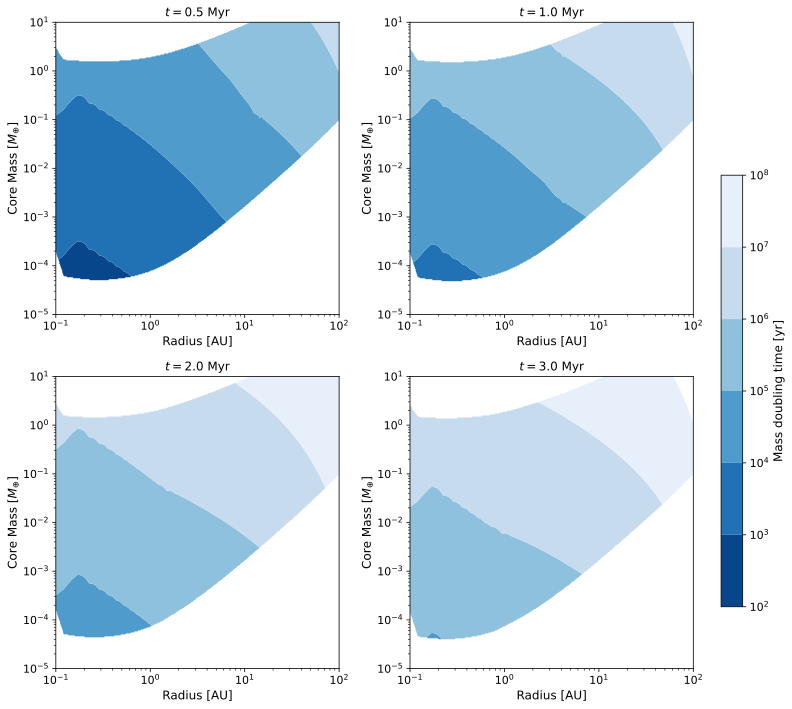

In [228]:
DIR = "output/A_booth_irr/"
DIR = "output/A_irr_winds/"
DIR = "output/A_irr/"


def t_contours(DIR, save = None):
    fig, ax = plt.subplots(2,2, figsize = (10,10))
    ax = ax.flatten()

    for i, file in enumerate(["0050", "0100", "0200", "0300"]):
        planet_data = PlanetSnapBetter(DIR)
        radii, masses, _, _, Mdots = planet_data.load_data('planet_'+f"{file}.dat")
        r_unique = np.unique(radii)
        m_unique = np.unique(masses)

        R_grid, M_grid = np.meshgrid(r_unique, m_unique)
        t_double = masses / Mdots / (2 * np.pi)
        t_double_grid = t_double.reshape(len(r_unique), len(m_unique))

        levels = [1e2,1e3,1e4,1e5,1e6,1e7,1e8]

        cp = ax[i].contourf(R_grid, M_grid, t_double_grid.T, norm=mcolors.LogNorm(), levels=levels, cmap='Blues_r')
        ax[i].set_xscale('log')
        ax[i].set_yscale('log')
        ax[i].set_xlabel('Radius [AU]', fontsize=12)
        ax[i].set_ylabel(r'Core Mass [$M_{\oplus}$]', fontsize=12)
        t = int(file)/100
        ax[i].set_title(fr"$t={t}$ Myr", fontsize=12)
        ax[i].tick_params(axis='both', which='major', labelsize=11)
        
    cbar_ax = fig.add_axes([1.01, 0.15, 0.03, 0.6])
    cbar = fig.colorbar(cp, ax=ax, shrink=0.75, aspect=30, pad=0.02, cax=cbar_ax)
    cbar.set_label('Mass doubling time [yr]', fontsize=12)
    cbar.ax.tick_params(labelsize=11)
    fig.tight_layout()
    fig.savefig(save)
    plt.show()

save = "/Users/safwankhan/Library/CloudStorage/OneDrive-UniversityofWaterloo/University/4B/PHYS 437B/Final Report/figures/A_irr_contours.svg"
t_contours(DIR, save)

In [215]:
np.shape(t_double_grid)
# np.size(t_double_grid)

(400, 300)

[1.00000000e-05 1.07189132e-05 1.14895100e-05 ... 8.70359136e+00
 9.32930403e+00 1.00000000e+01]
0.010353218432956616


/var/folders/80/3_r0dytx0g58z7ybrd36jc_40000gn/T/ipykernel_34068/3188640978.py:19: RuntimeWarning: divide by zero encountered in divide
  t_double = masses/Mdots/(2*np.pi)


(0.1, 100.0)

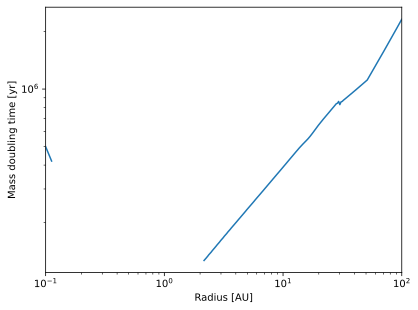

In [95]:
DIR = "output/A_booth/"

# n=40
n=100
planet_data = PlanetSnapBetter(DIR)
radii, masses, _, _, Mdots = planet_data.load_data('planet_0050.dat')
print(masses)
# print(radii)
indices = np.where(masses == masses[-10])
# indices = np.where(masses == masses[n])
# indices = np.where(radii == radii[n])
# print(indices)
print(masses[n])

radii = radii[indices]
masses = masses[indices]
Mdots = Mdots[indices]

t_double = masses/Mdots/(2*np.pi)

fig, ax = plt.subplots(1,1)
ax.loglog(radii, t_double)
ax.set_xlabel("Radius [AU]")
ax.set_ylabel("Mass doubling time [yr]")
ax.set_xlim(1e-1, 1e2)

/var/folders/80/3_r0dytx0g58z7ybrd36jc_40000gn/T/ipykernel_34068/2762997567.py:37: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  return cp.collections
/var/folders/80/3_r0dytx0g58z7ybrd36jc_40000gn/T/ipykernel_34068/2762997567.py:27: RuntimeWarning: divide by zero encountered in divide
  t_double = masses / Mdots / (2 * np.pi)


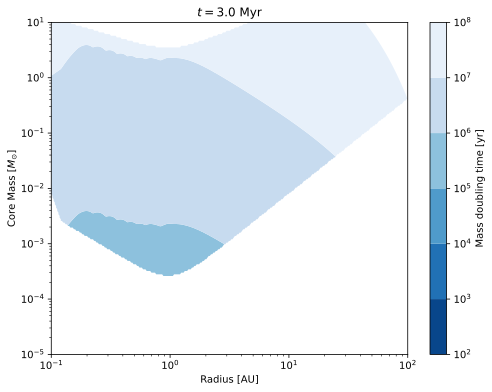

In [147]:
def planet_animation(DIR, out):

    frames = len(glob.glob(DIR+"planet_*"))

    planet_data = PlanetSnapBetter(DIR)
    radii, masses, _, _, Mdots = planet_data.load_data('planet_0000.dat')
    r_unique = np.unique(radii)
    m_unique = np.unique(masses)
    R_grid, M_grid = np.meshgrid(r_unique, m_unique)
    t_double = masses / Mdots / (2 * np.pi)
    t_double_grid = t_double.reshape(len(r_unique), len(m_unique)).T

    # Set up the figure and axes
    fig, ax = plt.subplots(figsize=(8, 6), dpi=200)
    levels = [1e2,1e3,1e4,1e5,1e6,1e7,1e8]
    norm = mcolors.LogNorm()
    cp = ax.contourf(R_grid, M_grid, t_double_grid, norm=norm, levels=levels, cmap='Blues_r')
    cbar = plt.colorbar(cp, ax=ax)
    cbar.set_label('Mass doubling time [yr]')

    def update(i):
        t = i/100
        i = f"{int(i):04d}"
        radii, masses, _, _, Mdots = planet_data.load_data(f'planet_{i}.dat')
        r_unique = np.unique(radii)
        m_unique = np.unique(masses)
        t_double = masses / Mdots / (2 * np.pi)
        t_double_grid = t_double.reshape(len(r_unique), len(m_unique)).T

        ax.clear()
        cp = ax.contourf(R_grid, M_grid, t_double_grid, levels=levels, norm=mcolors.LogNorm(), cmap='Blues_r')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('Radius [AU]')
        ax.set_ylabel(r'Core Mass [$M_{\odot}$]')
        ax.set_title(fr"$t={t}$ Myr")
        return cp.collections

    ani = animation.FuncAnimation(fig, update, frames=frames, blit=False)
    ani.save(out, fps=15)

# planet_animation("output/A_planets_fix/", "A_planets_fix.mp4")
# planet_animation("output/A_planets_wind_fix/", "A_planets_wind_fix.mp4")
# planet_animation("output/A_booth/", "A_booth.mp4")
planet_animation("output/A_simpledisc2/", "A_simpledisc2.mp4")